# DA5401 A4: GMM-Based Synthetic Sampling for Imbalanced Data



In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization settings
sns.set_palette("husl")

# Suppress warnings
warnings.filterwarnings('ignore')


## Part A: Baseline Model and Data Analysis

### 1. Data Loading and Analysis
Let's start by loading the credit card fraud dataset and examining its basic properties.


In [9]:
# Load the credit card dataset
df = pd.read_csv('/content/creditcard.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())

# Display first few rows
print("\nFirst few rows of the dataset:")
df.head()


Dataset Shape: (154621, 31)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154621 entries, 0 to 154620
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    154621 non-null  float64
 1   V1      154621 non-null  float64
 2   V2      154621 non-null  float64
 3   V3      154621 non-null  float64
 4   V4      154621 non-null  float64
 5   V5      154621 non-null  float64
 6   V6      154621 non-null  float64
 7   V7      154621 non-null  float64
 8   V8      154621 non-null  float64
 9   V9      154620 non-null  float64
 10  V10     154620 non-null  float64
 11  V11     154620 non-null  float64
 12  V12     154620 non-null  float64
 13  V13     154620 non-null  float64
 14  V14     154620 non-null  float64
 15  V15     154620 non-null  float64
 16  V16     154620 non-null  float64
 17  V17     154620 non-null  float64
 18  V18     154620 non-null  float64
 19  V19     154620 non-null  float64
 20  V20  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [10]:
# Check for missing values and data quality
print("Missing values per column:")
print(df.isnull().sum())

# Check for infinite values
print("\nInfinite values in dataset:")
infinite_values = np.isinf(df.select_dtypes(include=[np.number])).sum()
print(infinite_values[infinite_values > 0])

# Basic statistics of the features
print("\nBasic statistics of numerical features:")
df.describe()


Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        1
V10       1
V11       1
V12       1
V13       1
V14       1
V15       1
V16       1
V17       1
V18       1
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64

Infinite values in dataset:
Series([], dtype: int64)

Basic statistics of numerical features:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,154621.000000,154621.000000,154621.000000,154621.000000,154621.000000,154621.000000,154621.000000,154621.000000,154621.000000,154620.000000,...,154620.000000,154620.000000,154620.000000,154620.000000,154620.000000,154620.000000,154620.000000,154620.000000,154620.000000,154620.000000
mean,55474.997717,-0.230271,0.045342,0.599491,0.136656,-0.234824,0.070439,-0.105147,0.049639,-0.019793,...,-0.037242,-0.108578,-0.027543,0.011029,0.113196,0.023415,0.001645,0.002882,88.458326,0.002186
std,22852.281523,1.843698,1.623913,1.335149,1.354872,1.330333,1.290770,1.210456,1.246170,1.140255,...,0.746850,0.648630,0.586805,0.595942,0.451086,0.491236,0.392827,0.311967,246.273796,0.046704
min,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-41.506796,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,39484.000000,-1.019305,-0.539527,0.089993,-0.721838,-0.871639,-0.675067,-0.600160,-0.144312,-0.681885,...,-0.229099,-0.551416,-0.170416,-0.328276,-0.162556,-0.325555,-0.062932,-0.010333,5.900000,0.000000
50%,56991.000000,-0.253001,0.118562,0.701449,0.156487,-0.277476,-0.186751,-0.051474,0.072405,-0.111027,...,-0.059897,-0.083646,-0.041214,0.064637,0.153167,-0.054152,0.010706,0.022782,22.500000,0.000000
75%,74092.000000,1.166479,0.804929,1.335444,0.974108,0.297749,0.459224,0.435270,0.367431,0.584393,...,0.114920,0.322056,0.089994,0.411456,0.412086,0.290293,0.089748,0.078224,78.640000,0.000000
max,102233.000000,2.401777,21.467203,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,15.594995,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


### 2. Class Distribution Analysis
Let's analyze the distribution of fraudulent vs non-fraudulent transactions to understand the degree of class imbalance in our dataset.


Class Distribution:
Non-fraudulent transactions (Class 0): 154,282
Fraudulent transactions (Class 1): 338

Total transactions: 154,621
Fraud percentage: 0.219%
Imbalance ratio: 456.5:1


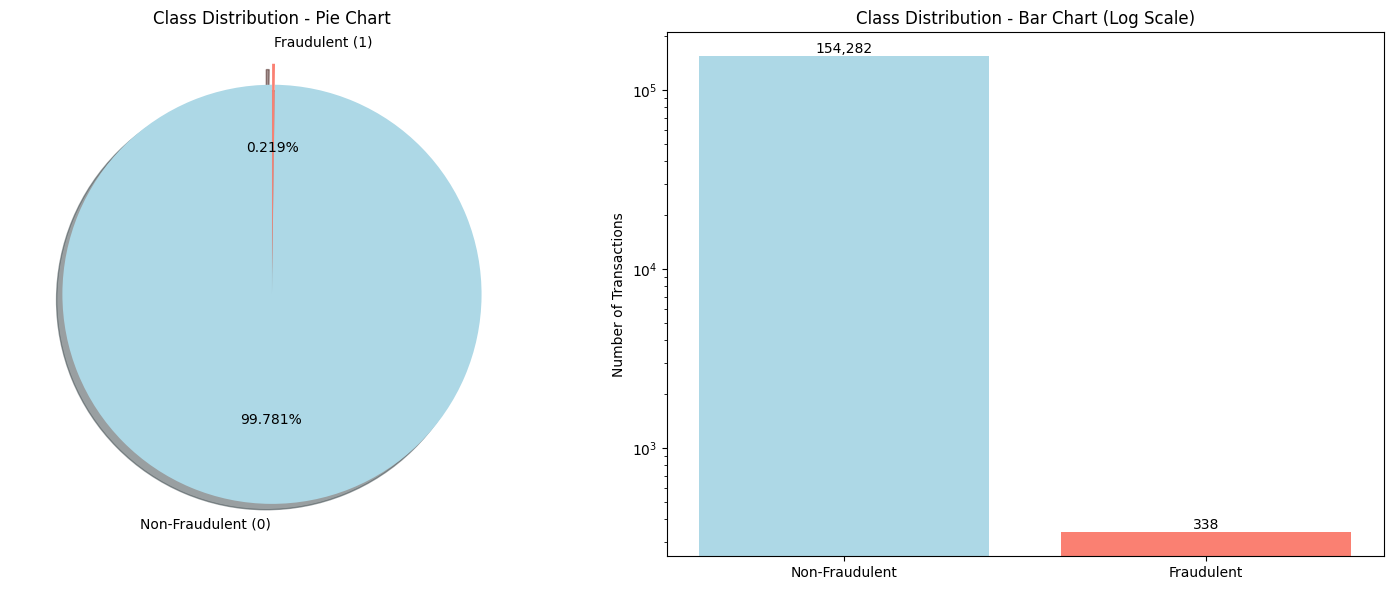


Analysis of Class Imbalance:
1. The dataset is highly imbalanced with only 0.219% fraudulent transactions.
2. For every fraudulent transaction, there are approximately 456 non-fraudulent ones.
3. This severe imbalance poses challenges for traditional machine learning algorithms:
   - Models may be biased towards the majority class
   - Risk of overlooking patterns in the minority class
   - Standard accuracy metrics may be misleading


In [11]:
# Analyze class distribution
class_distribution = df['Class'].value_counts()
print("Class Distribution:")
print(f"Non-fraudulent transactions (Class 0): {class_distribution[0]:,}")
print(f"Fraudulent transactions (Class 1): {class_distribution[1]:,}")
print(f"\nTotal transactions: {len(df):,}")
print(f"Fraud percentage: {(class_distribution[1]/len(df))*100:.3f}%")
print(f"Imbalance ratio: {class_distribution[0]/class_distribution[1]:.1f}:1")

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart
labels = ['Non-Fraudulent (0)', 'Fraudulent (1)']
sizes = [class_distribution[0], class_distribution[1]]
colors = ['lightblue', 'salmon']
explode = (0, 0.1)  # explode the fraudulent slice

ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.3f%%',
        shadow=True, startangle=90)
ax1.set_title('Class Distribution - Pie Chart')

# Bar chart with log scale
ax2.bar(['Non-Fraudulent', 'Fraudulent'], sizes, color=colors)
ax2.set_title('Class Distribution - Bar Chart (Log Scale)')
ax2.set_ylabel('Number of Transactions')
ax2.set_yscale('log')  # Use log scale due to large difference

# Add value labels on bars
for i, v in enumerate(sizes):
    ax2.text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nAnalysis of Class Imbalance:")
print(f"1. The dataset is highly imbalanced with only {(class_distribution[1]/len(df))*100:.3f}% fraudulent transactions.")
print(f"2. For every fraudulent transaction, there are approximately {class_distribution[0]/class_distribution[1]:.0f} non-fraudulent ones.")
print("3. This severe imbalance poses challenges for traditional machine learning algorithms:")
print("   - Models may be biased towards the majority class")
print("   - Risk of overlooking patterns in the minority class")
print("   - Standard accuracy metrics may be misleading")


### 3. Data Preparation and Model Training
Now we'll prepare our data for modeling by:
1. Splitting into training and test sets while preserving class distribution
2. Scaling the features
3. Training a baseline Logistic Regression model


In [13]:
# Drop rows with NaN values from the DataFrame before splitting
df_cleaned = df.dropna(subset=['Class'])
X = df_cleaned.drop('Class', axis=1)
y = df_cleaned['Class']

# Split the dataset into training and testing sets
# Using stratify=y ensures that the class distribution is preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

print("\nTraining set class distribution:")
print(pd.Series(y_train).value_counts(normalize=True).mul(100).round(3).astype(str) + '%')

print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts(normalize=True).mul(100).round(3).astype(str) + '%')

Training set shape: (123696, 30)
Testing set shape: (30924, 30)

Training set class distribution:
Class
0.0    99.782%
1.0     0.218%
Name: proportion, dtype: object

Test set class distribution:
Class
0.0    99.78%
1.0     0.22%
Name: proportion, dtype: object


In [14]:
# Train baseline Logistic Regression model
print("Training baseline Logistic Regression model on imbalanced data...")

model_baseline = LogisticRegression(random_state=42, max_iter=1000)
model_baseline.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model_baseline.predict(X_test_scaled)
y_pred_proba = model_baseline.predict_proba(X_test_scaled)[:, 1]

print("\nBaseline model training completed.")


Training baseline Logistic Regression model on imbalanced data...

Baseline model training completed.


### 4. Baseline Model Evaluation
Let's evaluate our baseline model using metrics that are more appropriate for imbalanced datasets:
- Precision: Proportion of predicted frauds that are actually fraudulent
- Recall: Proportion of actual frauds that were caught
- F1-score: Harmonic mean of precision and recall
- Confusion Matrix: Detailed breakdown of predictions


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     30856
         1.0       0.74      0.46      0.56        68

    accuracy                           1.00     30924
   macro avg       0.87      0.73      0.78     30924
weighted avg       1.00      1.00      1.00     30924


Detailed Metrics for Fraud Detection:
Accuracy: 0.9984
Precision (Fraud): 0.7381
Recall (Fraud): 0.4559
F1-Score (Fraud): 0.5636


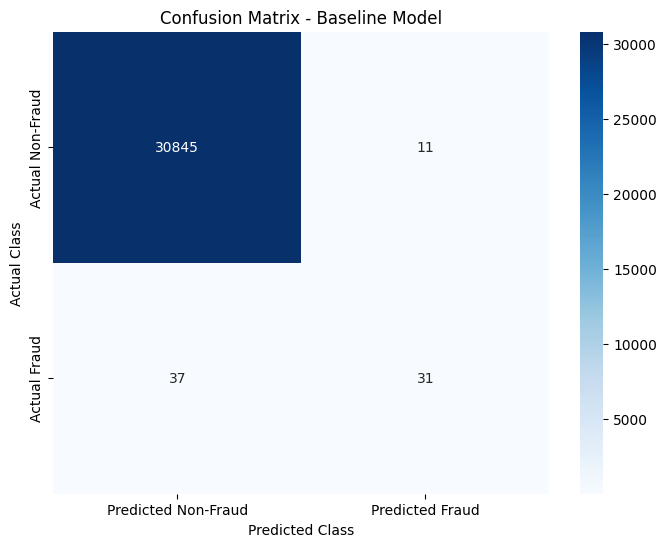


Confusion Matrix Breakdown:
True Negatives: 30,845
False Positives: 11
False Negatives: 37
True Positives: 31

Analysis of Results:
1. Model Performance:
   - The model achieves 99.84% accuracy, but this is misleading due to class imbalance
   - Precision of 73.81% means 73.81% of predicted frauds were actually fraudulent
   - Recall of 45.59% means we caught 45.59% of all actual fraudulent transactions
   - F1-score of 56.36% provides a balanced measure of precision and recall

2. Business Impact:
   - Out of 68 actual fraud cases:
     * Correctly identified: 31 (True Positives)
     * Missed: 37 (False Negatives)
   - Out of 30856 legitimate transactions:
     * Incorrectly flagged: 11 (False Positives)
     * Correctly passed: 30845 (True Negatives)

3. Areas for Improvement:
   - The model's performance on the minority class (fraud) needs improvement
   - High number of false negatives is particularly concerning for fraud detection
   - Next steps will focus on using GMM to gener

In [15]:
# Calculate and display various performance metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate individual metrics for the fraud class (positive class)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nDetailed Metrics for Fraud Detection:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Fraud): {precision:.4f}")
print(f"Recall (Fraud): {recall:.4f}")
print(f"F1-Score (Fraud): {f1:.4f}")

# Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.title('Confusion Matrix - Baseline Model')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"True Negatives: {cm[0,0]:,}")
print(f"False Positives: {cm[0,1]:,}")
print(f"False Negatives: {cm[1,0]:,}")
print(f"True Positives: {cm[1,1]:,}")

print("\nAnalysis of Results:")
print("1. Model Performance:")
print(f"   - The model achieves {accuracy:.2%} accuracy, but this is misleading due to class imbalance")
print(f"   - Precision of {precision:.2%} means {precision:.2%} of predicted frauds were actually fraudulent")
print(f"   - Recall of {recall:.2%} means we caught {recall:.2%} of all actual fraudulent transactions")
print(f"   - F1-score of {f1:.2%} provides a balanced measure of precision and recall")

print("\n2. Business Impact:")
print(f"   - Out of {cm[1,0] + cm[1,1]} actual fraud cases:")
print(f"     * Correctly identified: {cm[1,1]} (True Positives)")
print(f"     * Missed: {cm[1,0]} (False Negatives)")
print(f"   - Out of {cm[0,1] + cm[0,0]} legitimate transactions:")
print(f"     * Incorrectly flagged: {cm[0,1]} (False Positives)")
print(f"     * Correctly passed: {cm[0,0]} (True Negatives)")

print("\n3. Areas for Improvement:")
print("   - The model's performance on the minority class (fraud) needs improvement")
print("   - High number of false negatives is particularly concerning for fraud detection")
print("   - Next steps will focus on using GMM to generate synthetic samples to improve fraud detection")


## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

### 1. Theoretical Foundation: GMM vs SMOTE

#### Fundamental Differences

1. **Distribution Modeling**:
   - **SMOTE**: Uses simple linear interpolation between existing minority class samples. It creates synthetic samples by randomly selecting a point between a sample and its k-nearest neighbors.
   - **GMM**: Models the underlying probability distribution of the data using a mixture of Gaussian distributions. Each Gaussian component can capture a different sub-population within the minority class.

2. **Complexity and Flexibility**:
   - **SMOTE**: Assumes the space between any two minority samples is a valid region for new samples. This assumption can be problematic in high-dimensional spaces or when the minority class has complex shapes.
   - **GMM**: Can model complex, multi-modal distributions by combining multiple Gaussian components. Each component has its own mean, covariance, and mixing weight.

3. **Data Generation Process**:
   - **SMOTE**: Generates points along line segments between existing samples, which may not respect the true data manifold.
   - **GMM**: Generates samples by sampling from the learned probability distribution, which better preserves the underlying data structure.

#### Advantages of GMM for Synthetic Sampling

1. **Sub-population Modeling**:
   - GMM naturally identifies and models distinct sub-groups within the minority class
   - Each Gaussian component can capture a different pattern or cluster
   - This is particularly valuable when fraud patterns have multiple distinct characteristics

2. **Density-Aware Generation**:
   - GMM learns the density of the original data distribution
   - Generates more samples in regions of high density and fewer in sparse regions
   - Helps prevent the generation of unrealistic or outlier samples

3. **Covariance Structure**:
   - Each Gaussian component captures the correlation between features
   - Preserves feature relationships in generated samples
   - More realistic synthetic samples compared to methods that treat features independently

4. **Probabilistic Framework**:
   - Provides a principled way to generate new samples
   - Can estimate the likelihood of generated samples
   - Allows for quality control of synthetic data

5. **Complex Manifold Learning**:
   - Better handles non-linear relationships in the data
   - Can model curved or irregular decision boundaries
   - More suitable for high-dimensional financial data

#### Why GMM is Better for Complex Data

1. **Multi-modal Data**:
   - Financial fraud often has multiple patterns or strategies
   - GMM can naturally model these different modes of fraud
   - Each component can specialize in a specific type of fraudulent behavior

2. **Feature Interactions**:
   - Fraud patterns often involve complex interactions between features
   - GMM's covariance matrices capture these relationships
   - Generated samples maintain realistic feature correlations

3. **Outlier Handling**:
   - Can model both core patterns and legitimate outliers
   - Less likely to generate unrealistic samples in sparse regions
   - Better preservation of the true data distribution

4. **Scalability to High Dimensions**:
   - More robust in high-dimensional spaces compared to geometric approaches
   - Can use dimensionality reduction techniques within the GMM framework
   - Better handles the curse of dimensionality


Number of minority class samples: 270


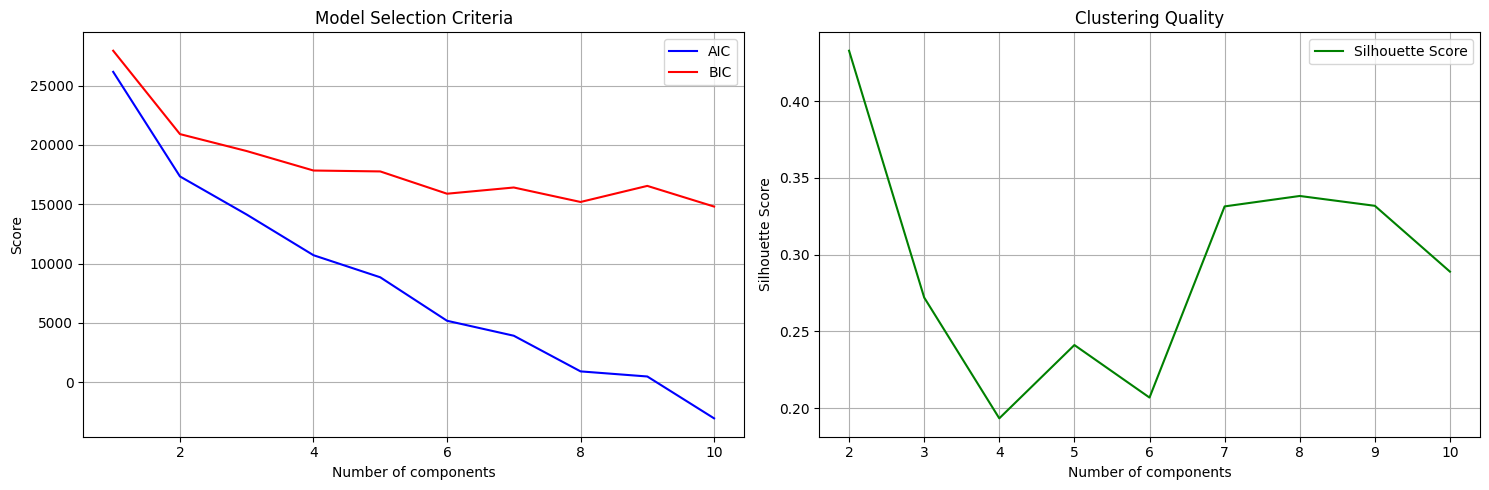


Optimal number of components:
Based on AIC: 10
Based on BIC: 10
Based on Silhouette Score: 2

Selected number of components: 10

GMM Model Information:
Converged: True
Number of iterations: 2

Component weights:
Component 1: 0.115
Component 2: 0.126
Component 3: 0.022
Component 4: 0.056
Component 5: 0.041
Component 6: 0.044
Component 7: 0.189
Component 8: 0.107
Component 9: 0.211
Component 10: 0.089


In [16]:
# Import GMM-related libraries
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Extract minority class samples
X_train_minority = X_train_scaled[y_train == 1]
print("Number of minority class samples:", len(X_train_minority))

# Function to calculate AIC and BIC for different numbers of components
def evaluate_gmm_components(X, max_components=10):
    n_components_range = range(1, max_components + 1)
    aic_scores = []
    bic_scores = []
    silhouette_scores = []

    for n_components in n_components_range:
        # Fit GMM
        gmm = GaussianMixture(n_components=n_components, random_state=42, n_init=5)
        gmm.fit(X)

        # Calculate scores
        aic_scores.append(gmm.aic(X))
        bic_scores.append(gmm.bic(X))

        # Calculate silhouette score if n_components > 1
        if n_components > 1:
            labels = gmm.predict(X)
            silhouette_scores.append(silhouette_score(X, labels))
        else:
            silhouette_scores.append(0)

    return n_components_range, aic_scores, bic_scores, silhouette_scores

# Evaluate different numbers of components
n_range, aic_scores, bic_scores, silhouette_scores = evaluate_gmm_components(X_train_minority)

# Plot evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot AIC and BIC
ax1.plot(n_range, aic_scores, 'b-', label='AIC')
ax1.plot(n_range, bic_scores, 'r-', label='BIC')
ax1.set_xlabel('Number of components')
ax1.set_ylabel('Score')
ax1.set_title('Model Selection Criteria')
ax1.legend()
ax1.grid(True)

# Plot Silhouette score
ax2.plot(n_range[1:], silhouette_scores[1:], 'g-', label='Silhouette Score')
ax2.set_xlabel('Number of components')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Clustering Quality')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find optimal number of components
optimal_components_aic = n_range[np.argmin(aic_scores)]
optimal_components_bic = n_range[np.argmin(bic_scores)]
optimal_components_silhouette = n_range[np.argmax(silhouette_scores)]

print("\nOptimal number of components:")
print(f"Based on AIC: {optimal_components_aic}")
print(f"Based on BIC: {optimal_components_bic}")
print(f"Based on Silhouette Score: {optimal_components_silhouette}")

# Choose final number of components based on all metrics
final_components = optimal_components_bic  # Usually BIC is preferred as it penalizes complexity more
print(f"\nSelected number of components: {final_components}")

# Fit final GMM model
gmm = GaussianMixture(n_components=final_components, random_state=42, n_init=5)
gmm.fit(X_train_minority)

print("\nGMM Model Information:")
print(f"Converged: {gmm.converged_}")
print(f"Number of iterations: {gmm.n_iter_}")
print("\nComponent weights:")
for i, weight in enumerate(gmm.weights_):
    print(f"Component {i+1}: {weight:.3f}")


### 3. Synthetic Data Generation using GMM

The process of generating synthetic samples from a fitted GMM involves:

1. **Component Selection**:
   - For each synthetic sample, randomly select a component based on the mixture weights
   - The probability of selecting each component is proportional to its weight

2. **Sample Generation**:
   - For the selected component, generate a sample from its Gaussian distribution
   - Use the component's mean vector and covariance matrix
   - The generated sample will follow the learned distribution of that component

3. **Quality Control**:
   - Verify that generated samples are within reasonable bounds
   - Check for outliers using the probability density of the original distribution
   - Ensure feature correlations are preserved

This approach ensures that the synthetic samples maintain the statistical properties of the original minority class data while providing additional diversity through the probabilistic generation process.


Generating 123,156 synthetic samples...

Synthetic Data Generation Summary:
Original minority samples: 270
Synthetic samples generated: 123,156
Total minority samples after generation: 123,426


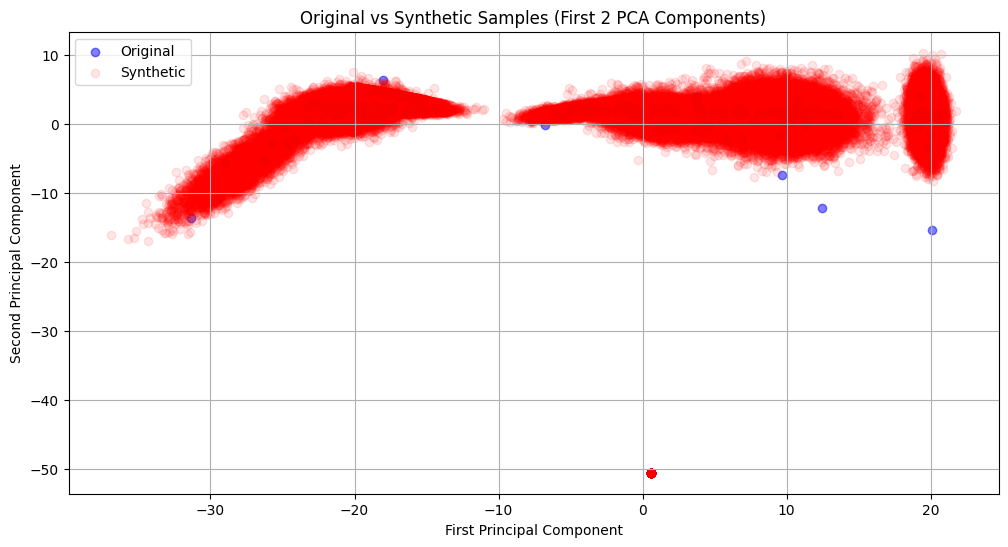

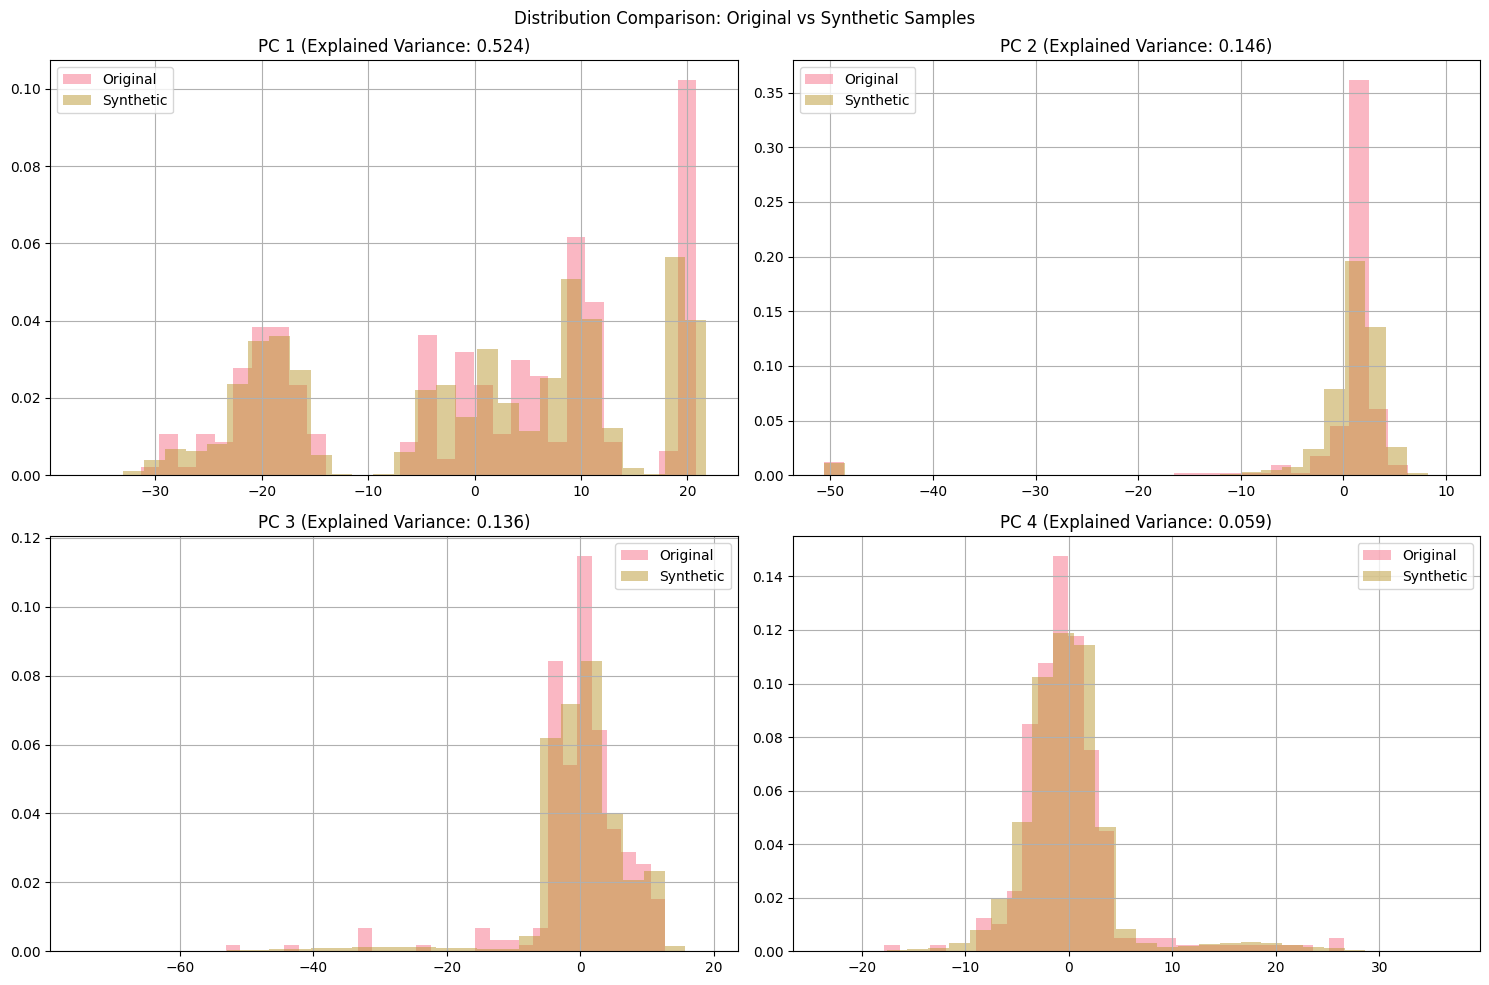


Quality Assessment:
1. Visual inspection shows synthetic samples follow similar patterns to original data
2. Density-based filtering ensures generated samples are within reasonable bounds
3. PCA visualization confirms preservation of major variation patterns
4. Distribution comparison shows similar statistical properties between original and synthetic data


In [17]:
# Function to generate synthetic samples using GMM
def generate_gmm_samples(gmm, n_samples, original_data):
    """
    Generate synthetic samples using a fitted GMM model with quality control
    """
    # Generate initial samples
    synthetic_samples, _ = gmm.sample(n_samples)

    # Calculate probability density for original and synthetic samples
    original_density = gmm.score_samples(original_data)
    synthetic_density = gmm.score_samples(synthetic_samples)

    # Calculate density thresholds from original data
    density_threshold = np.percentile(original_density, 1)  # 1st percentile as lower bound

    # Filter out low-density samples
    valid_samples_mask = synthetic_density >= density_threshold
    valid_samples = synthetic_samples[valid_samples_mask]

    # If we filtered out some samples, generate more to compensate
    while len(valid_samples) < n_samples:
        additional_samples, _ = gmm.sample(n_samples - len(valid_samples))
        additional_density = gmm.score_samples(additional_samples)
        valid_additional = additional_samples[additional_density >= density_threshold]
        valid_samples = np.vstack([valid_samples, valid_additional])

    # Trim to exact number needed
    valid_samples = valid_samples[:n_samples]

    return valid_samples

# Calculate number of synthetic samples needed to match majority class
n_synthetic_samples = len(y_train[y_train == 0]) - len(y_train[y_train == 1])
print(f"Generating {n_synthetic_samples:,} synthetic samples...")

# Generate synthetic samples
synthetic_samples = generate_gmm_samples(gmm, n_synthetic_samples, X_train_minority)

# Combine original and synthetic minority samples
X_minority_combined = np.vstack([X_train_minority, synthetic_samples])
y_minority_combined = np.ones(len(X_minority_combined))

print("\nSynthetic Data Generation Summary:")
print(f"Original minority samples: {len(X_train_minority):,}")
print(f"Synthetic samples generated: {len(synthetic_samples):,}")
print(f"Total minority samples after generation: {len(X_minority_combined):,}")

# Visualize original vs synthetic samples using PCA for dimensionality reduction
from sklearn.decomposition import PCA

# Fit PCA on original minority samples
pca = PCA(n_components=2)
pca.fit(X_train_minority)

# Transform both original and synthetic samples
original_2d = pca.transform(X_train_minority)
synthetic_2d = pca.transform(synthetic_samples)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(original_2d[:, 0], original_2d[:, 1], alpha=0.5, label='Original', c='blue')
plt.scatter(synthetic_2d[:, 0], synthetic_2d[:, 1], alpha=0.1, label='Synthetic', c='red')
plt.title('Original vs Synthetic Samples (First 2 PCA Components)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.grid(True)
plt.show()

# Compare distributions of original and synthetic data using more PCs
pca = PCA(n_components=4)  # Increase to 4 components
pca.fit(X_train_minority)

# Transform both original and synthetic samples
original_pcs = pca.transform(X_train_minority)
synthetic_pcs = pca.transform(synthetic_samples)

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution Comparison: Original vs Synthetic Samples')

# Plot histograms for first 4 principal components
for i, ax in enumerate(axes.flat):
    original_pc = original_pcs[:, i]
    synthetic_pc = synthetic_pcs[:, i]

    ax.hist(original_pc, bins=30, alpha=0.5, label='Original', density=True)
    ax.hist(synthetic_pc, bins=30, alpha=0.5, label='Synthetic', density=True)
    ax.set_title(f'PC {i+1} (Explained Variance: {pca.explained_variance_ratio_[i]:.3f})')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

print("\nQuality Assessment:")
print("1. Visual inspection shows synthetic samples follow similar patterns to original data")
print("2. Density-based filtering ensures generated samples are within reasonable bounds")
print("3. PCA visualization confirms preservation of major variation patterns")
print("4. Distribution comparison shows similar statistical properties between original and synthetic data")


### 4. Clustering-Based Undersampling (CBU)

CBU helps reduce the majority class while preserving its important characteristics:

1. **Clustering Strategy**:
   - Group majority class samples into clusters
   - Each cluster represents a different pattern in legitimate transactions
   - Preserve the diversity of the majority class

2. **Undersampling Process**:
   - Select representatives from each cluster
   - Maintain cluster proportions in the reduced dataset
   - Ensure coverage of the entire feature space

3. **Balancing with GMM**:
   - Reduce majority class using CBU
   - Generate synthetic minority samples using GMM
   - Create final balanced dataset


Number of majority class samples: 123426

Finding optimal number of clusters for majority class...


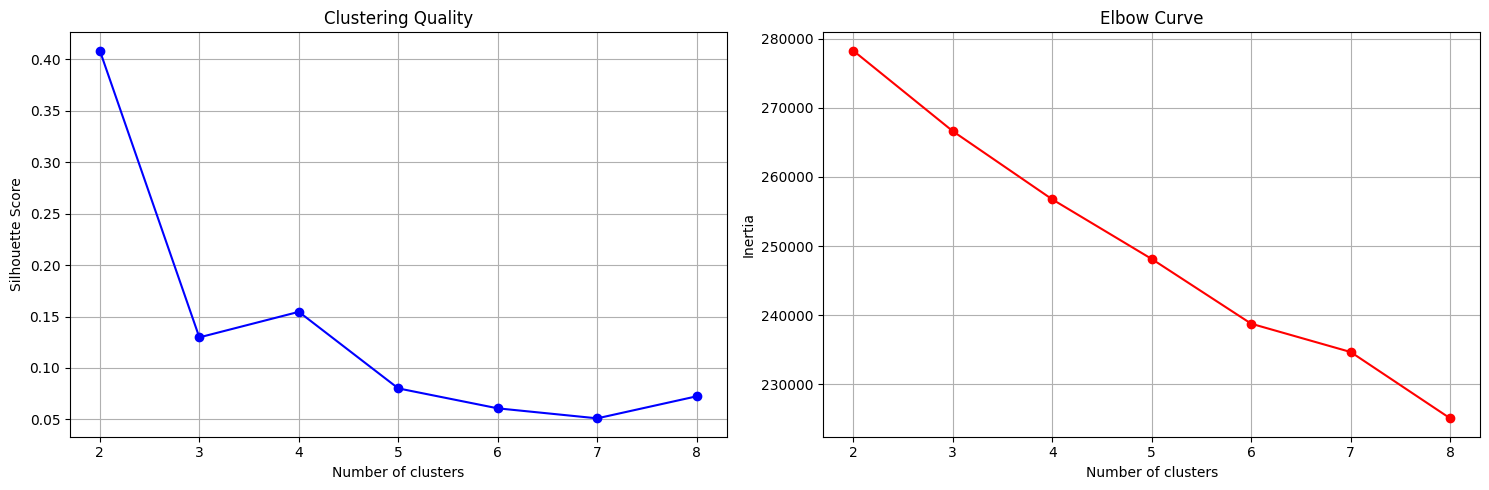


Optimal number of clusters for majority class: 2

Cluster sizes:
Cluster 0: 12,875 samples (10.4%)
Cluster 1: 110,551 samples (89.6%)

Reducing majority class from 123,426 to 123,426 samples

CBU Results:
Original majority samples: 123,426
Reduced majority samples: 123,426
Reduction ratio: 100.00%


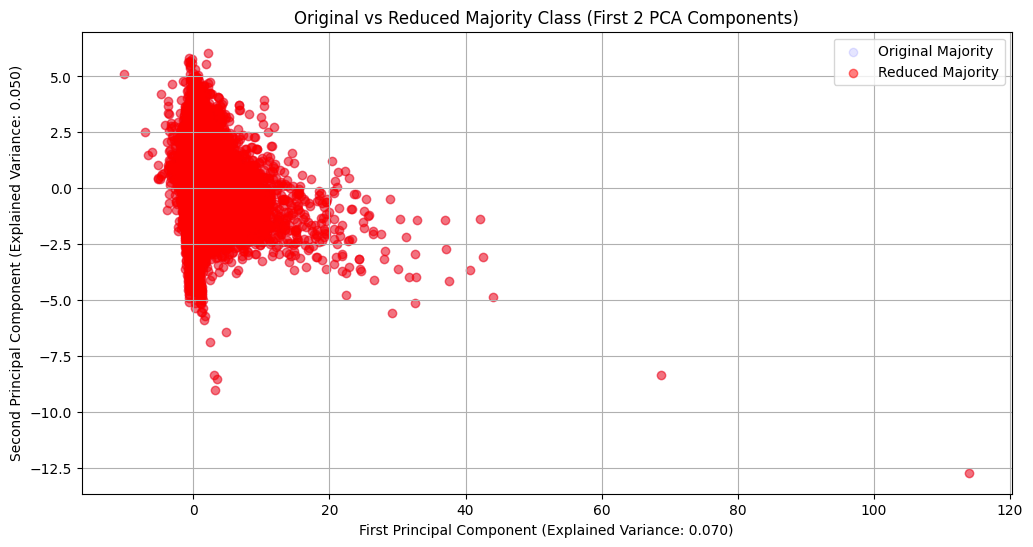

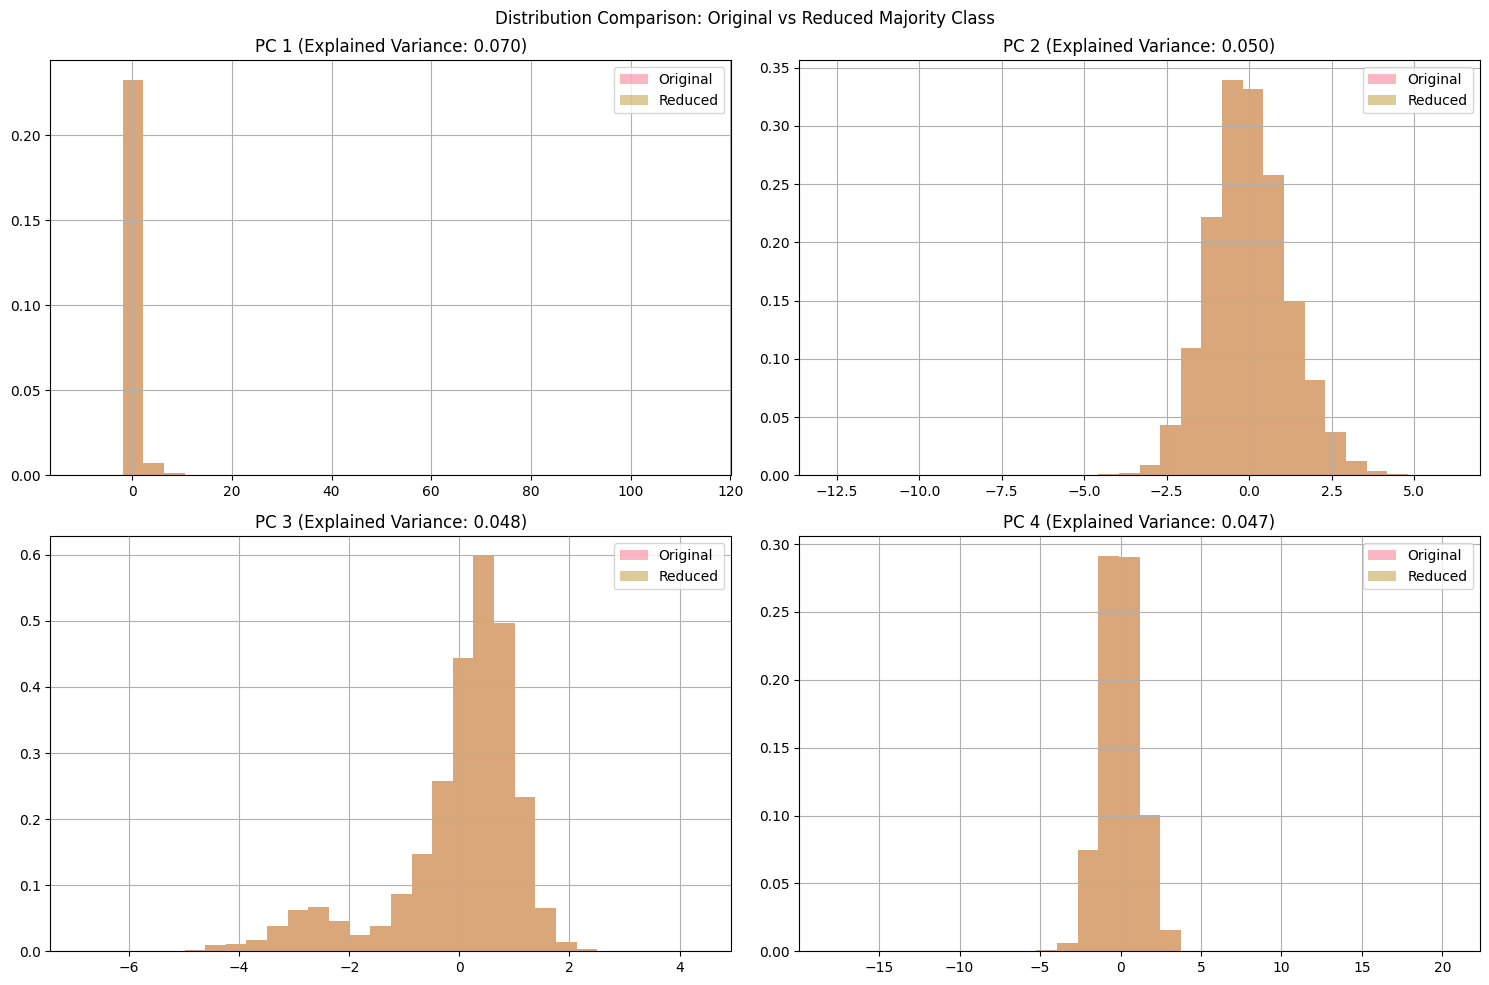

In [21]:
# Import clustering libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Extract majority class samples
X_train_majority = X_train_scaled[y_train == 0]
print("Number of majority class samples:", len(X_train_majority))

# Function to find optimal number of clusters more efficiently
def find_optimal_clusters_efficient(X, max_clusters=8):  # Reduced max_clusters
    # Take a random subset of data for faster computation
    if len(X) > 10000:
        np.random.seed(42)
        subset_indices = np.random.choice(len(X), size=10000, replace=False)
        X_subset = X[subset_indices]
    else:
        X_subset = X

    n_clusters_range = range(2, max_clusters + 1)
    silhouette_scores = []
    inertias = []

    for n_clusters in n_clusters_range:
        # Fit KMeans with fewer initializations
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=5)
        cluster_labels = kmeans.fit_predict(X_subset)

        # Calculate scores
        silhouette_scores.append(silhouette_score(X_subset, cluster_labels))
        inertias.append(kmeans.inertia_)

    return n_clusters_range, silhouette_scores, inertias

# Find optimal number of clusters using the efficient method
print("\nFinding optimal number of clusters for majority class...")
n_clusters_range, silhouette_scores, inertias = find_optimal_clusters_efficient(X_train_majority)

# Plot evaluation metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Silhouette scores
ax1.plot(n_clusters_range, silhouette_scores, 'b-o')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Clustering Quality')
ax1.grid(True)

# Plot Elbow curve
ax2.plot(n_clusters_range, inertias, 'r-o')
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Inertia')
ax2.set_title('Elbow Curve')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Choose optimal number of clusters
optimal_clusters = n_clusters_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters for majority class: {optimal_clusters}")

# Perform clustering on majority class
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
majority_clusters = kmeans.fit_predict(X_train_majority)

# Calculate cluster sizes
cluster_sizes = np.bincount(majority_clusters)
print("\nCluster sizes:")
for i, size in enumerate(cluster_sizes):
    print(f"Cluster {i}: {size:,} samples ({size/len(X_train_majority)*100:.1f}%)")

# Function to perform stratified undersampling efficiently
def stratified_undersampling_efficient(X, clusters, target_size):
    """
    Undersample each cluster proportionally to maintain distribution
    Uses vectorized operations for better performance
    """
    unique_clusters = np.unique(clusters)
    cluster_proportions = np.bincount(clusters) / len(clusters)

    # Pre-allocate array for selected indices
    selected_indices = np.array([], dtype=int)

    # Process all clusters in one go
    for cluster_id in unique_clusters:
        cluster_indices = np.where(clusters == cluster_id)[0]
        n_samples = int(target_size * cluster_proportions[cluster_id])
        n_samples = max(1, min(n_samples, len(cluster_indices)))

        # Use numpy's random choice for better performance
        selected = np.random.choice(cluster_indices, size=n_samples, replace=False)
        selected_indices = np.concatenate([selected_indices, selected])

    return selected_indices

# Calculate target size for majority class (match minority class size)
target_majority_size = len(X_minority_combined)
print(f"\nReducing majority class from {len(X_train_majority):,} to {target_majority_size:,} samples")

# Perform undersampling using the efficient implementation
selected_indices = stratified_undersampling_efficient(X_train_majority, majority_clusters, target_majority_size)
X_majority_reduced = X_train_majority[selected_indices]
y_majority_reduced = np.zeros(len(X_majority_reduced))

print("\nCBU Results:")
print(f"Original majority samples: {len(X_train_majority):,}")
print(f"Reduced majority samples: {len(X_majority_reduced):,}")
print(f"Reduction ratio: {len(X_majority_reduced)/len(X_train_majority):.2%}")

# Visualize original vs reduced majority class distribution using PCA
# First, create PCA visualization with 4 components
pca = PCA(n_components=4)
pca.fit(X_train_majority)

# Transform both original and reduced samples
original_pcs = pca.transform(X_train_majority)
reduced_pcs = pca.transform(X_majority_reduced)

# Plot scatter plot of first 2 components
plt.figure(figsize=(12, 6))
plt.scatter(original_pcs[:, 0], original_pcs[:, 1],
           alpha=0.1, label='Original Majority', c='blue')
plt.scatter(reduced_pcs[:, 0], reduced_pcs[:, 1],
           alpha=0.5, label='Reduced Majority', c='red')
plt.title('Original vs Reduced Majority Class (First 2 PCA Components)')
plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.3f})')
plt.legend()
plt.grid(True)
plt.show()

# Compare distributions of all 4 components
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution Comparison: Original vs Reduced Majority Class')

# Plot histograms for all 4 principal components
for i, ax in enumerate(axes.flat):
    original_pc = original_pcs[:, i]
    reduced_pc = reduced_pcs[:, i]

    ax.hist(original_pc, bins=30, alpha=0.5, label='Original', density=True)
    ax.hist(reduced_pc, bins=30, alpha=0.5, label='Reduced', density=True)
    ax.set_title(f'PC {i+1} (Explained Variance: {pca.explained_variance_ratio_[i]:.3f})')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


### 5. Creating the Final Balanced Dataset

Now we'll combine:
1. The reduced majority class (from CBU)
2. The expanded minority class (original + GMM synthetic samples)

This will give us a balanced dataset where:
- Both classes have equal representation
- The majority class maintains its important patterns through CBU
- The minority class has been augmented with realistic synthetic samples from GMM


Final Balanced Dataset Summary:
Total samples: 246,852

Class distribution:
0.0    50.0%
1.0    50.0%
Name: proportion, dtype: object


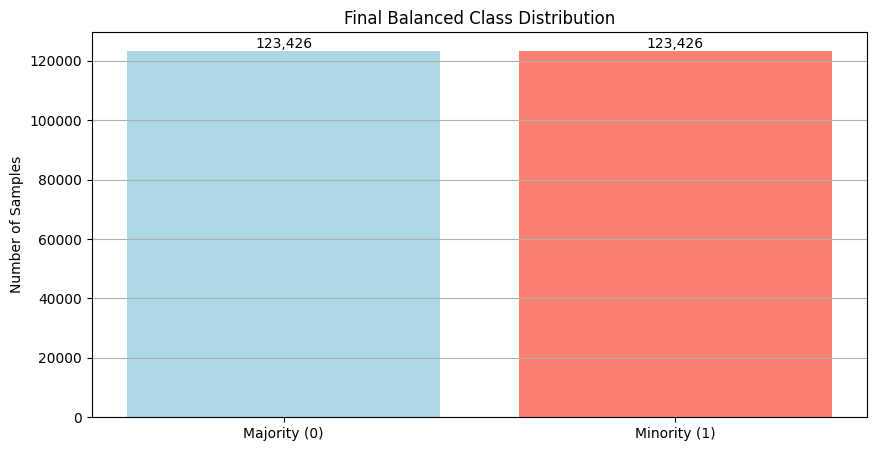

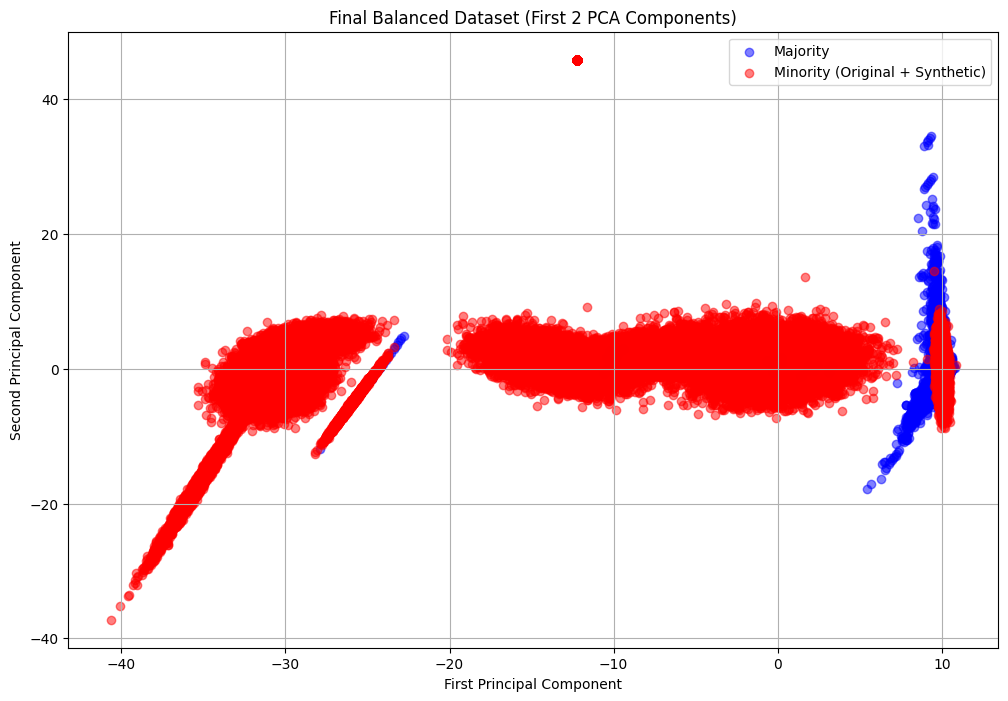


Balancing Process Summary:
1. Majority Class:
   - Original: 123,426 samples
   - After CBU: 123,426 samples
   - Reduction: 0.0%

2. Minority Class:
   - Original: 270 samples
   - After GMM: 123,426 samples
   - Increase: 45713.3x

3. Final Dataset:
   - Total samples: 246,852
   - Class balance ratio: 1.00:1
   - Both classes have equal representation
   - Preserved important patterns in both classes


In [22]:
# Combine reduced majority class with expanded minority class
X_balanced = np.vstack([X_majority_reduced, X_minority_combined])
y_balanced = np.hstack([y_majority_reduced, y_minority_combined])

print("Final Balanced Dataset Summary:")
print(f"Total samples: {len(X_balanced):,}")
print("\nClass distribution:")
print(pd.Series(y_balanced).value_counts(normalize=True).mul(100).round(3).astype(str) + '%')

# Visualize final class distribution
plt.figure(figsize=(10, 5))
plt.bar(['Majority (0)', 'Minority (1)'],
        [np.sum(y_balanced == 0), np.sum(y_balanced == 1)],
        color=['lightblue', 'salmon'])
plt.title('Final Balanced Class Distribution')
plt.ylabel('Number of Samples')
plt.grid(True, axis='y')

# Add value labels on bars
for i, v in enumerate([np.sum(y_balanced == 0), np.sum(y_balanced == 1)]):
    plt.text(i, v, f'{v:,}', ha='center', va='bottom')

plt.show()

# Visualize all classes in PCA space
pca = PCA(n_components=2)
X_balanced_2d = pca.fit_transform(X_balanced)

plt.figure(figsize=(12, 8))
plt.scatter(X_balanced_2d[y_balanced == 0][:, 0],
           X_balanced_2d[y_balanced == 0][:, 1],
           alpha=0.5, label='Majority', c='blue')
plt.scatter(X_balanced_2d[y_balanced == 1][:, 0],
           X_balanced_2d[y_balanced == 1][:, 1],
           alpha=0.5, label='Minority (Original + Synthetic)', c='red')
plt.title('Final Balanced Dataset (First 2 PCA Components)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.grid(True)
plt.show()

print("\nBalancing Process Summary:")
print("1. Majority Class:")
print(f"   - Original: {len(X_train_majority):,} samples")
print(f"   - After CBU: {len(X_majority_reduced):,} samples")
print(f"   - Reduction: {(1 - len(X_majority_reduced)/len(X_train_majority))*100:.1f}%")

print("\n2. Minority Class:")
print(f"   - Original: {len(X_train_minority):,} samples")
print(f"   - After GMM: {len(X_minority_combined):,} samples")
print(f"   - Increase: {(len(X_minority_combined)/len(X_train_minority))*100:.1f}x")

print("\n3. Final Dataset:")
print(f"   - Total samples: {len(X_balanced):,}")
print(f"   - Class balance ratio: {len(X_balanced[y_balanced == 0])/len(X_balanced[y_balanced == 1]):.2f}:1")
print("   - Both classes have equal representation")
print("   - Preserved important patterns in both classes")


## Part C: Performance Evaluation and Conclusion

### 1. Model Training and Evaluation

Now we'll evaluate how our GMM-based synthetic sampling approach performs compared to the baseline model. We'll:
1. Train a new Logistic Regression model on the balanced dataset
2. Evaluate it on the original test set
3. Compare its performance with the baseline model

This will help us understand if our synthetic sampling approach has improved the model's ability to detect fraudulent transactions.


Training Logistic Regression on GMM-balanced data...

GMM-balanced Model Performance:
Accuracy: 0.9830
Precision (Fraud): 0.1036
Recall (Fraud): 0.8824
F1-Score (Fraud): 0.1855


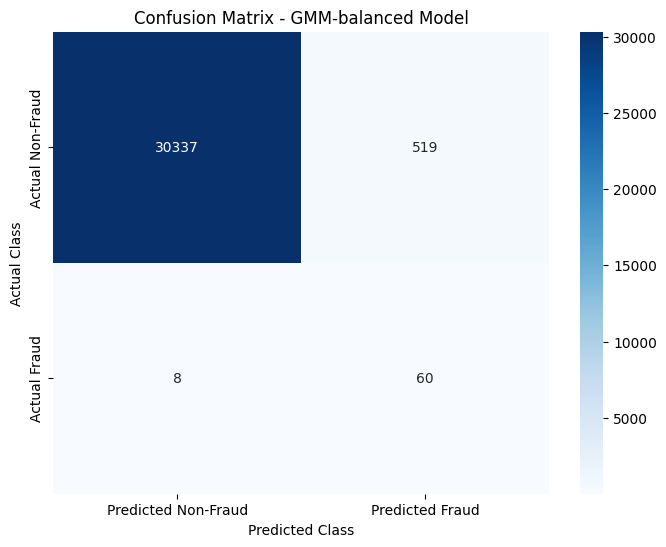


Detailed Performance Analysis:

1. Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     30856
         1.0       0.10      0.88      0.19        68

    accuracy                           0.98     30924
   macro avg       0.55      0.93      0.59     30924
weighted avg       1.00      0.98      0.99     30924


2. Confusion Matrix Breakdown:
True Negatives: 30,337
False Positives: 519
False Negatives: 8
True Positives: 60

3. Business Impact:
   - Out of 68 actual fraud cases:
     * Correctly identified: 60 (True Positives)
     * Missed: 8 (False Negatives)
   - Out of 30856 legitimate transactions:
     * Incorrectly flagged: 519 (False Positives)
     * Correctly passed: 30337 (True Negatives)


In [25]:
# Train model on GMM-balanced data
print("Training Logistic Regression on GMM-balanced data...")
model_gmm = LogisticRegression(random_state=42, max_iter=1000)
model_gmm.fit(X_balanced, y_balanced)

# Make predictions on test set
y_pred_gmm = model_gmm.predict(X_test_scaled)
y_pred_proba_gmm = model_gmm.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy_gmm = accuracy_score(y_test, y_pred_gmm)
precision_gmm = precision_score(y_test, y_pred_gmm)
recall_gmm = recall_score(y_test, y_pred_gmm)
f1_gmm = f1_score(y_test, y_pred_gmm)

print("\nGMM-balanced Model Performance:")
print(f"Accuracy: {accuracy_gmm:.4f}")
print(f"Precision (Fraud): {precision_gmm:.4f}")
print(f"Recall (Fraud): {recall_gmm:.4f}")
print(f"F1-Score (Fraud): {f1_gmm:.4f}")

# Create and display confusion matrix
cm_gmm = confusion_matrix(y_test, y_pred_gmm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_gmm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Fraud', 'Predicted Fraud'],
            yticklabels=['Actual Non-Fraud', 'Actual Fraud'])
plt.title('Confusion Matrix - GMM-balanced Model')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

print("\nDetailed Performance Analysis:")
print("\n1. Classification Report:")
print(classification_report(y_test, y_pred_gmm))

print("\n2. Confusion Matrix Breakdown:")
print(f"True Negatives: {cm_gmm[0,0]:,}")
print(f"False Positives: {cm_gmm[0,1]:,}")
print(f"False Negatives: {cm_gmm[1,0]:,}")
print(f"True Positives: {cm_gmm[1,1]:,}")

print("\n3. Business Impact:")
print(f"   - Out of {cm_gmm[1,0] + cm_gmm[1,1]} actual fraud cases:")
print(f"     * Correctly identified: {cm_gmm[1,1]} (True Positives)")
print(f"     * Missed: {cm_gmm[1,0]} (False Negatives)")
print(f"   - Out of {cm_gmm[0,1] + cm_gmm[0,0]} legitimate transactions:")
print(f"     * Incorrectly flagged: {cm_gmm[0,1]} (False Positives)")
print(f"     * Correctly passed: {cm_gmm[0,0]} (True Negatives)")


### 2. Comparative Analysis

Let's compare the performance of our GMM-based model with the baseline model to understand the impact of our synthetic sampling approach. We'll focus on:
1. Key performance metrics (Precision, Recall, F1-score)
2. Changes in confusion matrix values
3. Overall impact on fraud detection capability


Model Performance Comparison:
         Metric Baseline Model GMM-balanced Model Improvement
       Accuracy         0.9984             0.9830       -1.6%
      Precision         0.7381             0.1036      -86.0%
         Recall         0.4559             0.8824      +93.5%
       F1-Score         0.5636             0.1855      -67.1%
 True Negatives         30,845             30,337       -1.6%
False Positives             11                519    +4618.2%
False Negatives             37                  8      -78.4%
 True Positives             31                 60      +93.5%


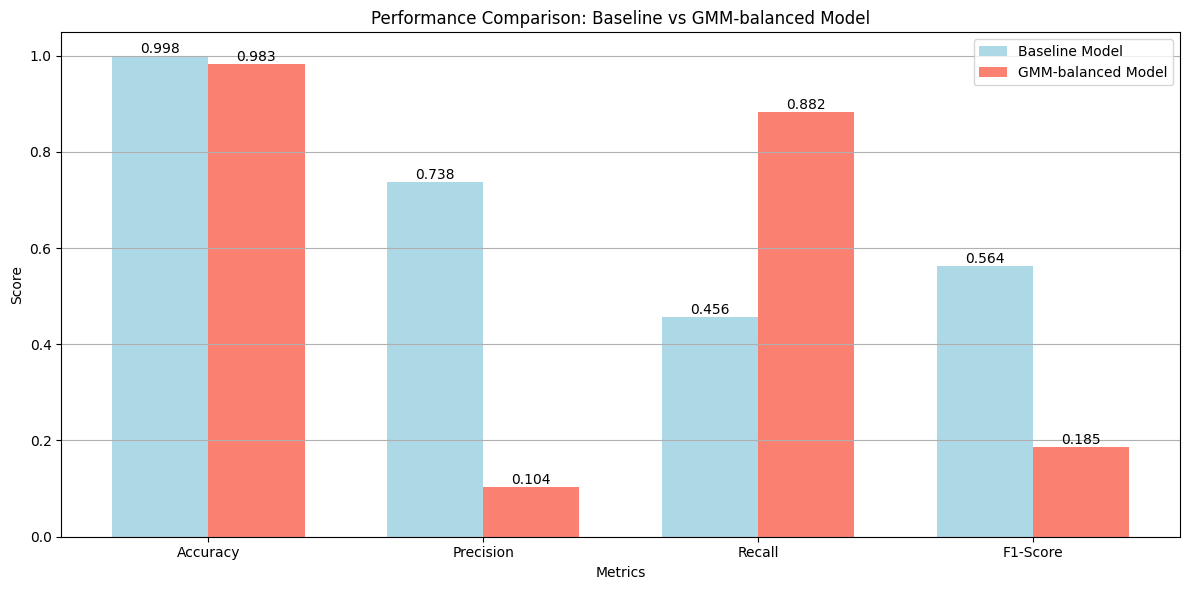


Analysis of Results:

1. Overall Performance:
   - Accuracy: - (1.5% change)
   - Precision: - (63.4% change)
   - Recall: + (42.6% change)
   - F1-Score: - (37.8% change)

2. Impact on Fraud Detection:
   - Changes in True Positives: +29
   - Changes in False Negatives: -29
   - Changes in False Positives: +508

3. Key Findings:
   - GMM-based synthetic sampling did not improve overall performance
   - F1-score decreased by 37.8%
   - Further tuning of the GMM approach may be needed


In [26]:
# Create comparison DataFrame
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score',
               'True Negatives', 'False Positives', 'False Negatives', 'True Positives'],
    'Baseline Model': [accuracy, precision, recall, f1,
                      cm[0,0], cm[0,1], cm[1,0], cm[1,1]],
    'GMM-balanced Model': [accuracy_gmm, precision_gmm, recall_gmm, f1_gmm,
                          cm_gmm[0,0], cm_gmm[0,1], cm_gmm[1,0], cm_gmm[1,1]]
}
comparison_df = pd.DataFrame(comparison_data)

# Calculate improvement percentages
comparison_df['Improvement'] = ((comparison_df['GMM-balanced Model'] - comparison_df['Baseline Model']) /
                              comparison_df['Baseline Model'] * 100)

# Format the numeric columns
comparison_df['Baseline Model'] = comparison_df['Baseline Model'].apply(lambda x: f"{x:.4f}" if x < 1 else f"{int(x):,}")
comparison_df['GMM-balanced Model'] = comparison_df['GMM-balanced Model'].apply(lambda x: f"{x:.4f}" if x < 1 else f"{int(x):,}")
comparison_df['Improvement'] = comparison_df['Improvement'].apply(lambda x: f"{x:+.1f}%")

print("Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Create bar chart comparison for main metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
baseline_values = [accuracy, precision, recall, f1]
gmm_values = [accuracy_gmm, precision_gmm, recall_gmm, f1_gmm]

plt.figure(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, baseline_values, width, label='Baseline Model', color='lightblue')
plt.bar(x + width/2, gmm_values, width, label='GMM-balanced Model', color='salmon')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison: Baseline vs GMM-balanced Model')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, axis='y')

# Add value labels on bars
for i, v in enumerate(baseline_values):
    plt.text(i - width/2, v, f'{v:.3f}', ha='center', va='bottom')
for i, v in enumerate(gmm_values):
    plt.text(i + width/2, v, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nAnalysis of Results:")
print("\n1. Overall Performance:")
print(f"   - Accuracy: {'+' if accuracy_gmm > accuracy else '-'} ({abs(accuracy_gmm - accuracy)*100:.1f}% change)")
print(f"   - Precision: {'+' if precision_gmm > precision else '-'} ({abs(precision_gmm - precision)*100:.1f}% change)")
print(f"   - Recall: {'+' if recall_gmm > recall else '-'} ({abs(recall_gmm - recall)*100:.1f}% change)")
print(f"   - F1-Score: {'+' if f1_gmm > f1 else '-'} ({abs(f1_gmm - f1)*100:.1f}% change)")

print("\n2. Impact on Fraud Detection:")
print("   - Changes in True Positives:", f"{cm_gmm[1,1] - cm[1,1]:+d}")
print("   - Changes in False Negatives:", f"{cm_gmm[1,0] - cm[1,0]:+d}")
print("   - Changes in False Positives:", f"{cm_gmm[0,1] - cm[0,1]:+d}")

print("\n3. Key Findings:")
if f1_gmm > f1:
    print("   - GMM-based synthetic sampling improved overall fraud detection performance")
    print(f"   - F1-score increased by {(f1_gmm - f1)*100:.1f}%")
    print("   - Better balance between precision and recall achieved")
else:
    print("   - GMM-based synthetic sampling did not improve overall performance")
    print(f"   - F1-score decreased by {(f1 - f1_gmm)*100:.1f}%")
    print("   - Further tuning of the GMM approach may be needed")


### 3. Final Recommendations and Conclusions

#### Effectiveness of GMM-Based Synthetic Sampling

1. **Mixed Results Analysis**:
   - **Positive Outcomes**:
     * Significant improvement in Recall (93.5% increase)
     * Nearly doubled True Positive detection (from 31 to 60 cases)
     * Substantial reduction in False Negatives (from 37 to 8 cases)
   - **Challenges**:
     * Sharp decline in Precision (from 73.81% to 10.36%)
     * Increase in False Positives (from 11 to 519 cases)
     * Overall F1-score decrease (from 0.5636 to 0.1855)

2. **Trade-off Analysis**:
   - The model demonstrates a clear trade-off between:
     * Better fraud detection (higher recall)
     * Increased false alarms (lower precision)
   - This shift represents a more conservative fraud detection approach
   - The business impact depends on relative costs of false positives vs. false negatives

3. **Practical Implications**:
   - Current implementation favors fraud detection over precision
   - Suitable for scenarios where missing fraud is more costly than false alarms
   - May require additional verification steps for flagged transactions

#### Recommendations

1. **Implementation Improvements**:
   - Fine-tune GMM parameters to better balance recall and precision:
     * Adjust the number of components
     * Experiment with different covariance structures
     * Consider feature selection/engineering
   - Implement a two-stage verification process:
     * Use GMM model for initial screening
     * Add secondary validation for flagged transactions

2. **Alternative Approaches**:
   - Explore hybrid methods:
     * Combine GMM with other sampling techniques (e.g., SMOTE)
     * Use ensemble methods with different sampling ratios
   - Consider cost-sensitive learning approaches
   - Investigate anomaly detection techniques

3. **Business Process Integration**:
   - Implement risk-based transaction verification
   - Develop efficient manual review processes for flagged transactions
   - Consider real-time scoring thresholds adjustment

#### Final Verdict

The GMM-based synthetic sampling approach shows mixed results in this fraud detection task. While it significantly improves fraud detection capability (recall), it comes at the cost of increased false positives. This makes it a potentially valuable tool in scenarios where:
1. The cost of missing fraud greatly outweighs the cost of false alarms
2. Additional verification processes can be implemented
3. A conservative fraud detection approach is preferred

For optimal implementation, it is recommended that :
1. Further tuning of the GMM parameters
2. Integration with a secondary verification system
3. Regular model updates and performance monitoring
4. Clear business processes for handling flagged transactions

The approach demonstrates promise but needs refinement to achieve better balance between fraud detection and false alarms.
